# Usage of Keras for image_classification


* configure random transformations and normalization operations to be done on your image data during training
* instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [28]:
import os
curr_dir = %pwd
proj_dir = os.path.normpath(os.path.join(curr_dir, os.path.pardir))

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization

import numpy as np
seed = 13
np.random.seed(seed)

Using TensorFlow backend.


### GPU configuration, disregard if non-GPU

In [2]:
## use only 30 % of the memory
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

In [3]:
# imports to display the svg image of the network
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

import pydot
import graphviz

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
batch_size = 32

# train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, width_shift_range=0.1,
                                  height_shift_range=0.1,zoom_range=0.1)

# only rescaling augmentation for test samples
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_dir = '../data/processed/train'
test_dir = '../data/processed/test'

In [8]:
%pwd

'/Users/ericleijonmarck/dev/dicommunify/notebooks'

In [12]:
# this is a generaotr that will read pictures 
# found in sub folders of 'data/train',
# and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
                train_dir,
                target_size=(100,50),
                shuffle=True,
                color_mode='grayscale',
                batch_size=batch_size,
                class_mode='categorical') # since we use categoricalentropy loss

Found 400 images belonging to 5 classes.


In [13]:
# this is a similar generatr, for validation/test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(100,50),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical')

Found 100 images belonging to 5 classes.


# inspirational architectures taken from 
[brain_segmentation](https://github.com/naldeborgh7575/brain_segmentation/blob/master/code/Segmentation_Models.py)
[image_classification](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)



In [14]:
nb_train_samples = 400
nb_test_samples = 100

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=(100,50,1), padding='same',
                 kernel_regularizer=regularizers.l2(0.001),activity_regularizer=regularizers.l1(0.001)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3), padding='same'))#, kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(5))
model.add(Activation('softmax'))

from keras.optimizers import Adam
          
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

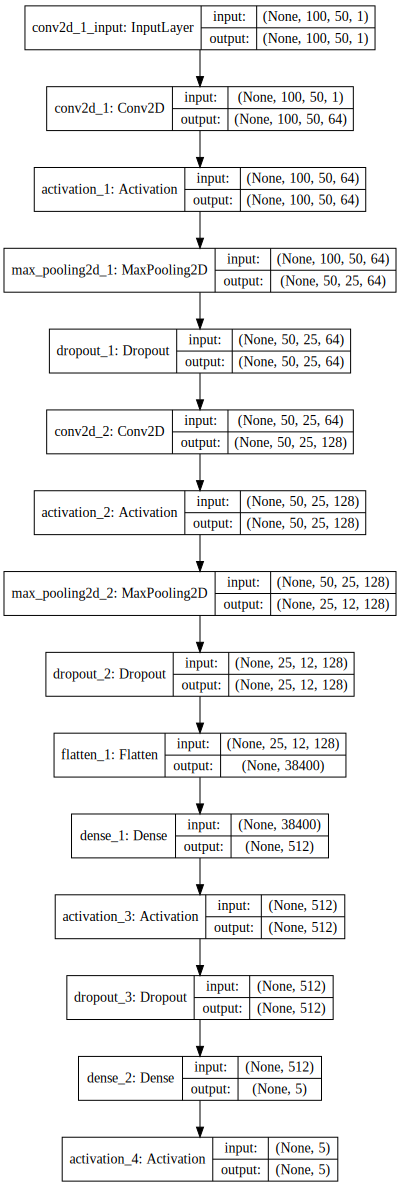

In [16]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 50, 64)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 50, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 25, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 25, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 25, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 12, 128)       0         
__________

In [19]:
run_count = 0

In [21]:
run_count += 1
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir="./summary/run_{}".format(run_count), 
                         histogram_freq=2, write_graph=True, 
                         write_images=True)

model.fit_generator(train_generator,
                   steps_per_epoch=nb_train_samples // batch_size,
                   epochs=120,
                   validation_data=test_generator,
                   validation_steps=nb_test_samples // batch_size,
                   callbacks=[tbCallBack])

model.save_weights('first_try.h5')
model.save('my_model.h5')

INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.
INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.
INFO:tensorflow:Summ

KeyboardInterrupt: 

## Testing to predict to see outcome of the predictions

In [29]:
import random

In [31]:
test_data_path = "data/processed/test/Body"
random_image = random.choice(os.listdir(test_filepath))
test__image_filepath = os.path.normpath(os.path.join(proj_dir, test_data_path, random_image))

In [32]:
import scipy.misc
proj_dir = os.path.curdir
image = scipy.misc.imread(test_image_filepath,mode='L')
image = scipy.misc.imresize(image, (100,50))
image = image / 255
image = np.expand_dims(image, axis=2)

model.save('../models/80_mf.h5')
image = image.reshape((1,) + image.shape)
model.predict_proba(image, verbose=1, batch_size=1)

1/1 [==============================] - 0s


array([[  9.74491298e-01,   1.81158148e-02,   3.50045832e-03,
          8.41598317e-04,   3.05083441e-03]], dtype=float32)

In [33]:
model.predict(image)

array([[  9.74491298e-01,   1.81158148e-02,   3.50045832e-03,
          8.41598317e-04,   3.05083441e-03]], dtype=float32)

In [34]:
train_generator.class_indices

{'Body': 0,
 'Head-Neck': 1,
 'Lower-Limb': 2,
 'True-Negative': 3,
 'Upper-Limb': 4}